# How can frog grow its tail back?


## Data accession

Load data from the link directly or load it through Courseworks .zip file.

In [1]:
!wget -O frogtail.zip "https://ftp.ebi.ac.uk/biostudies/fire/E-MTAB-/716/E-MTAB-7716/Files/arrayExpressUpload.zip"

/bin/bash: wget: command not found


## Make an anndata matrix using scanpy or anndata

Usually single cell data is either directly stored in highdimensional files with .h5 extensions or in compressed count matrices with several tsv/csv/json logging the covariates information. Here is an example of how to compress and download this data into an anndata object that facilitates downstream single cell analysis.

- AnnData object for single cell data:  [Documentation](https://https://anndata.readthedocs.io/en/latest/tutorials/notebooks/getting-started.html)
- Scanpy for single cell analysis: [Documentation](https://scanpy.readthedocs.io/en/stable/index.html)



In [ ]:
# Imports
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
from scipy.io import mmread

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, adjusted_rand_score, calinski_harabasz_score

import magic
import scipy.sparse as sp
from scanpy.external.pp import harmony_integrate

In [2]:
# Loading Data
X = mmread('ArrayExpress/countsMatrix.mtx') # compressed sparse matrix of gene expression
genes = pd.read_csv('ArrayExpress/genes.csv', sep=' ', header=None) # col names of genes
cells = pd.read_csv('ArrayExpress/cells.csv', sep=' ', header=None) # row names of cells
labels = pd.read_csv('ArrayExpress/labels.csv')
meta = pd.read_csv('ArrayExpress/meta.csv')


X = X.tocsr()
adata = ad.AnnData(X.T) # creating an AnnData object

In [3]:
# Adding Cell and Gene Information to AnnData (adata)
cells.columns = ['barcode_cells']
meta_aug = pd.merge(meta, labels, left_on='sample', right_on='Sample', how='left')

adata.var_names = genes[0]
adata.obs = pd.merge(cells, meta_aug, left_on='barcode_cells', right_on='cell')

adata.write_h5ad('cleaned_processed_frogtail.h5ad')

/opt/anaconda3/envs/FrogTail/lib/python3.11/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


## Load data

In [4]:
# Loading Clean Data
adata = ad.read_h5ad('cleaned_processed_frogtail.h5ad') 

## Processing data

In [5]:
# Creating a Copy of the Data
adata.layers["counts"] = adata.X.copy()

# Normalizing and Logaritmizing the Data
sc.pp.normalize_total(adata)
sc.pp.log1p(adata) 

# Filtering Genes and Cells
sc.pp.filter_genes(adata, min_cells=3) 
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.highly_variable_genes(adata, n_top_genes=2300) #Finds the top 2300 variable genes

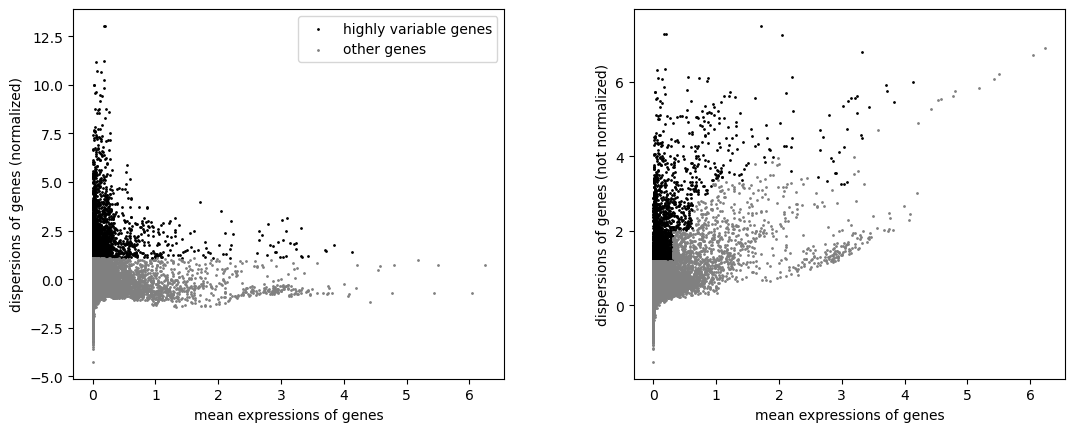

In [6]:
sc.pl.highly_variable_genes(adata)

In [7]:
# Saving the highly variable genes
adata_hvg = adata[:, adata.var['highly_variable']].copy()
sc.pp.scale(adata_hvg, max_value=10)

/opt/anaconda3/envs/FrogTail/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


## Data Denoising 

In [8]:
def run_magic(adata):
    "Runs the MAGIC denoising algorithm"
    ad = adata.copy()
    
    magic_op = magic.MAGIC(random_state=0, n_pca=50)
    X_magic = magic_op.fit_transform(ad.X)
    ad.X = np.array(X_magic, dtype=np.float32)
    
    return ad


def run_knn_smooth(ad, k=15, use_rep='X_pca'):
    "Runs the KNN smoothing algorithm"
    ad = ad.copy()

    sc.pp.neighbors(ad, n_neighbors=k, use_rep=use_rep)
    C = ad.obsp['connectivities'].tocsr()
    X = ad.X.toarray() if sp.issparse(ad.X) else ad.X
    row_norm = 1.0 / np.clip(C.sum(1).A1, 1e-12, None)
    ad.X = (C.multiply(row_norm[:, None]) @ X).astype(np.float32)
    
    return ad


# Choosing which dataset I want to run
adata_use_d = adata_hvg  # no denoising
#adata_use_d = run_magic(adata_hvg)  
#adata_use_d = run_knn_smooth(adata_hvg)   

sc.pp.pca(adata_use_d, n_comps=30, svd_solver='arpack')

## Batch Integration over time

In [9]:
def run_harmony(adata, batch_key="batch", n_pcs=50):
    "Runs Harmony batch correction"
    ad = adata.copy()

    assert batch_key in ad.obs.columns, f"{batch_key!r} not found in .obs"
    ad.obs[batch_key] = ad.obs[batch_key].astype(str).astype("category")

    sc.pp.pca(ad, n_comps=n_pcs, svd_solver="arpack")
    harmony_integrate(ad, key=batch_key)  
    ad.uns["use_rep"] = "X_pca_harmony"
    
    return ad


def run_combat(adata, batch_key='batch'):
    "Runs Combat batch correction"
    ad = adata.copy()
    sc.pp.combat(ad, key=batch_key)       
    sc.pp.pca(ad, svd_solver='arpack')    
    return ad

adata_use = adata_use_d #no batch integration
# adata_use = run_harmony(adata_use_d)
# adata_use = run_combat(adata_use_d)


## Clustering Analysis

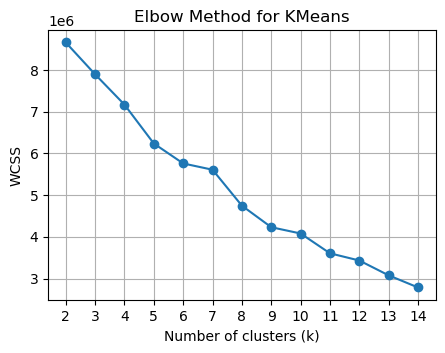

In [11]:
# The elbow method
X_embed = adata_use.obsm["X_pca"]

K_RANGE = range(2, 15)
wcss = []  

for k in K_RANGE:
    km = KMeans(n_clusters=k, random_state=0, n_init="auto")
    km.fit(X_embed)
    wcss.append(km.inertia_)

plt.figure(figsize=(5, 3.5))
plt.plot(K_RANGE, wcss, marker="o")
plt.xticks(list(K_RANGE))
plt.xlabel("Number of clusters (k)")
plt.ylabel("WCSS")   
plt.title("Elbow Method for KMeans")
plt.grid()
plt.show()

/opt/anaconda3/envs/FrogTail/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


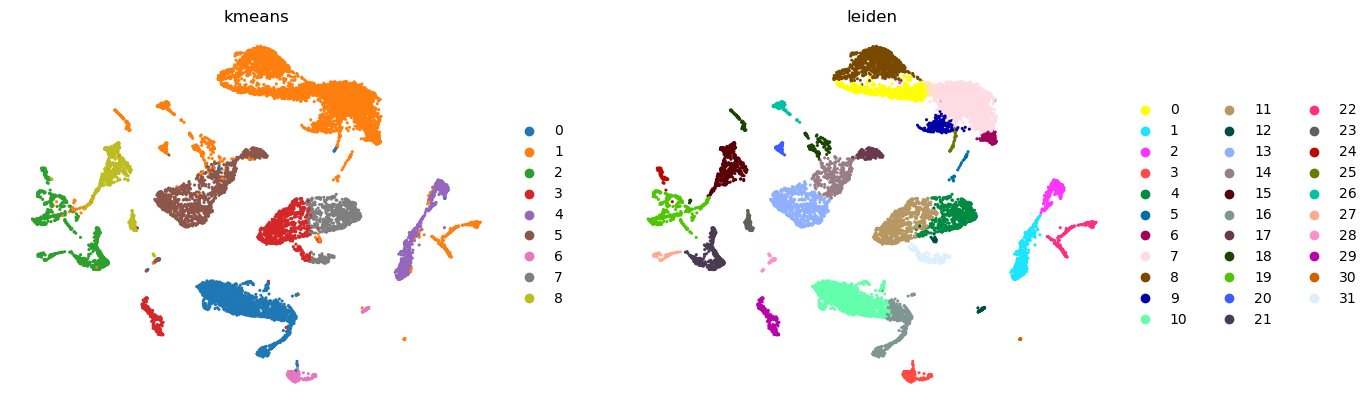

,Model,Silhouette,Calinski-Harabasz,ARI
0,Kmeans,0.447981,2419.057617,NaN
1,Leiden,0.280465,2157.752686,NaN
2,Kmeans vs Leiden,-,-,0.423627


In [12]:
#  UMAP
sc.pp.neighbors(adata_use, use_rep='X_pca', n_neighbors=10, random_state=0, metric='cosine')  
sc.tl.umap(adata_use, min_dist=0.3, random_state=0)    

# K-means
k = 9
kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto")
adata_use.obs['kmeans'] = kmeans.fit_predict(adata_use.obsm['X_pca']).astype(str)

# Leiden
sc.tl.leiden(adata_use, resolution=0.6, key_added="leiden", random_state=0, flavor="igraph", n_iterations=2)

# Plot
sc.pl.umap(adata_use, color=["kmeans", "leiden"], legend_loc="right margin", size=20, frameon=False)

# Metrics
X = adata_use.obsm["X_pca"]
k = np.asarray(adata_use.obs["kmeans"]).astype(str)
l = np.asarray(adata_use.obs["leiden"]).astype(str)

the_metrics = pd.DataFrame([
    {"Model":"Kmeans", "Silhouette": silhouette_score(X,k), "Calinski-Harabasz": calinski_harabasz_score(X,k)},
    {"Model":"Leiden", "Silhouette": silhouette_score(X,l), "Calinski-Harabasz": calinski_harabasz_score(X,l)},
    {"Model":"Kmeans vs Leiden", "Silhouette":"-", "Calinski-Harabasz":"-", "ARI": float(adjusted_rand_score(k,l))}])
the_metrics
    


In [16]:
# Information about the clusters

def cluster_summary(adata, by_key, label_key="cluster"):
    "Summerizes the cell type composition within clusters"
    
    total_cells_per_cluster = adata.obs[by_key].value_counts().sort_index()
    cluster_celltype_counts = pd.crosstab(adata.obs[by_key], adata.obs[label_key])
    
    # dominant label and its count
    top_label = cluster_celltype_counts.idxmax(axis=1)
    top2_label = cluster_celltype_counts.apply(lambda row: row.sort_values(ascending=False).index[1], axis=1)
    
    top_count = cluster_celltype_counts.max(axis=1)
    top2_count = cluster_celltype_counts.apply(lambda row: row.sort_values(ascending=False).iloc[1], axis=1)

    top_prop  = (top_count / total_cells_per_cluster).round(3)
    top2_prop  = (top2_count / cluster_celltype_counts.sum(axis=1)).round(3)


    data = pd.DataFrame({
        "cluster": total_cells_per_cluster.index.astype(str),
        "n_cells": total_cells_per_cluster.values,
        "top_cell_type": top_label.values,
        "top2_cell_type": top2_label.values,

        "top_cell_count": top_count.values,
        "top2_cell_count": top2_count.values,

        "top_cell_prop": top_prop.values
    })
    
    cluster_to_label = dict(zip(total_cells_per_cluster.index.astype(str), top_label.tolist()))

    return data, cluster_to_label

kmeans_table, top_list_kmeans = cluster_summary(adata_use, by_key="kmeans", label_key="cluster")
leiden_table, top_list_leiden = cluster_summary(adata_use, by_key="leiden", label_key="cluster")


In [14]:
kmeans_table

,cluster,n_cells,top_cell_type,top2_cell_type,top_cell_count,top2_cell_count,top_cell_prop
0,0,2086,Epidermis,ROCs,1772,249,0.849
1,1,5619,Erythrocyte 1,Erythrocyte 3,2758,979,0.491
2,2,820,Vulnerable Motor Neuron,Interneuron 1,282,125,0.344
3,3,991,Goblet cell,Small secretory cell,971,13,0.980
4,4,708,Myeloid 1,Myeloid 2,452,250,0.638
5,5,1291,Sclerotome,Myotome,729,294,0.565
6,6,263,Beta ionocyte,Alpha ionocyte,204,56,0.776
7,7,752,Goblet cell,Small secretory cell,745,4,0.991
8,8,669,Spinal cord progenitor,Floor plate,493,106,0.737


In [15]:
leiden_table

,cluster,n_cells,top_cell_type,top2_cell_type,top_cell_count,top2_cell_count,top_cell_prop
0,0,718,Erythrocyte 4,Erythrocyte 1,491,162,0.684
1,1,464,Myeloid 1,Myeloid 2,462,2,0.996
2,2,267,Myeloid 2,Myeloid 1,258,6,0.966
3,3,212,Beta ionocyte,Epidermis,204,4,0.962
4,4,573,Goblet cell,Epidermis,570,1,0.995
5,5,27,Goblet cell,Erythrocyte 1,16,9,0.593
6,6,100,Erythrocyte 1,Erythrocyte 2,88,7,0.880
7,7,2544,Erythrocyte 1,Erythrocyte 3,2067,248,0.812
8,8,1141,Erythrocyte 3,Erythrocyte 1,663,229,0.581
9,9,227,Erythrocyte 1,Erythrocyte 2,192,15,0.846


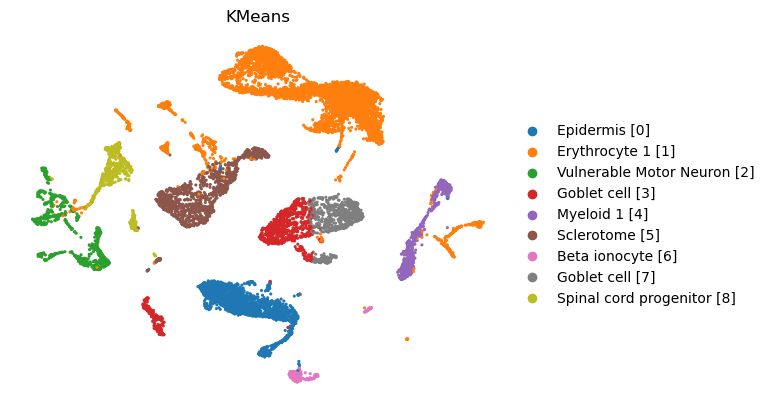

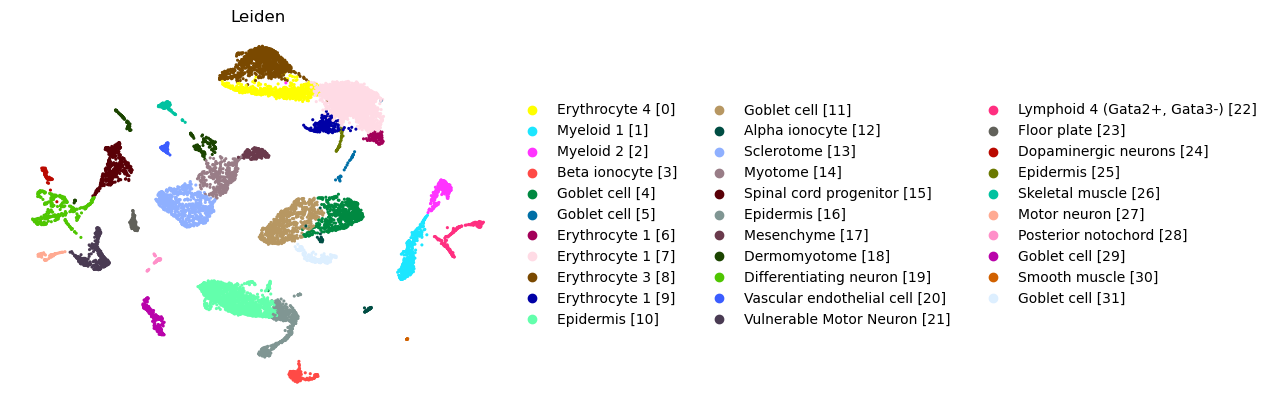

In [18]:
# Plotting with cluster labels

for key in ["kmeans", "leiden"]:
    adata_use.obs[key] = adata_use.obs[key].astype("category")

# Finding the most dominant label per cluster 
k_tbl, k_map = cluster_summary(adata_use, by_key="kmeans", label_key="cluster")
l_tbl, l_map = cluster_summary(adata_use, by_key="leiden", label_key="cluster")

def plot_with_cluster_labels(key, label_map, title=None):
    "Plots UMAP with clusters labeled by their assigned names"

    cluster_ID = adata_use.obs[key].cat.categories
    Name_of_clusters = [f"{label_map.get(c, c)} [{c}]" for c in cluster_ID] # Name and ID
    new_key = f"{key}_named"
    adata_use.obs[new_key] = adata_use.obs[key].cat.rename_categories(Name_of_clusters)
    adata_use.uns[f"{new_key}_colors"] = adata_use.uns[f"{key}_colors"].copy()
    
    # get axis, set title
    ax = sc.pl.umap(adata_use, color=new_key, legend_loc="right margin", size=20, frameon=False, show=False)

    # Title of the plot
    if title:
        ax.set_title(title)
    plt.show()

# Plotting K-means and Leiden with labels for the clusters
plot_with_cluster_labels("kmeans", k_map, title="KMeans")
plot_with_cluster_labels("leiden", l_map, title="Leiden")

## Marker Selection and Gene Analysis

In [19]:
# Wilcoxon
sc.tl.rank_genes_groups(adata_use, groupby="leiden", method="wilcoxon", n_genes=200, key_added="rank_WilcoxonLeiden")

# Logistic Regression
sc.tl.rank_genes_groups(adata_use, groupby="leiden", method="logreg", n_genes=200, key_added="rank_LogReg")

/opt/anaconda3/envs/FrogTail/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/anaconda3/envs/FrogTail/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/anaconda3/envs/FrogTail/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/anaconda3/envs/FrogTail/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/anaconda3/envs/FrogTail/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] =

Number of ROC genes in the dataset: 33
Leiden cluster enriched for ROC genes: 16
Overlap of ROC markers in Wilcoxon and LogReg, top50): 19
['Xelaev18017960m.g', 'Xelaev18026267m.g', 'Xelaev18038148m.g', 'apoc1.like.L', 'bhlha9.S', 'cldn6.2.S', 'col14a1.S', 'cpamd8.L', 'egfl6.L', 'fn1.S', 'frem2.1.L', 'krt18.L', 'loc100490088.L', 'mapk12.like.1.L', 'megf6.S']
Overlap with Table S3 (ignoring .L/.S): 2
Overlap genes: ['egfl6', 'frem2.1']


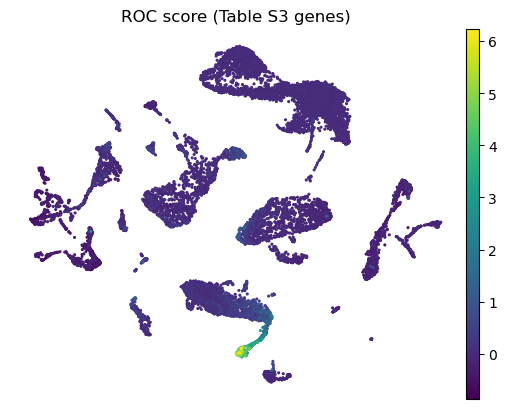

Wilcoxon top 50 hits in Table S3: 2 -> ['egfl6', 'frem2.1']
LogReg   top 50 hits in Table S3: 12 -> ['dlx2', 'egfl6', 'fbn2', 'fgf9', 'frem2.1', 'jag1', 'lamb2', 'loc100488523', 'lpar3', 'nid2', 'sp9', 'vwde']


In [20]:
# Supplementary Table 3
Table_S3 = ["wnt5a","loc100488523","loc100492954","egfl6","lpar3","cpa6","sp9",
    "fgf9","fbn2","tinagl1","fgf7","vwde","lef1","lamb2","fgfr4","fgf7",
    "rspo2","cpa6","loc100498358","krt","loc100486832","jag1",
    "Xelaev18043128m","dlx2","tp73","gdf6","Xelaev18046800m","nid2",
    "igfbp2","ism2","dlx2","loc100493805","frem2","Xelaev18044182m",
    "bmp5","tspear","sema3f","robo4","jchain","rspo2","adamts18","pltp",
    "Xelaev18034799m","lamb1","lamb1","unc5b","mmp28","fgf10","pzp","galnt15"]

# To handle case sensitivity
vn  = pd.Series(adata_use.var_names, name="var")
vnl = vn.str.lower()

def find_hits(g, allow_substring=False):
    "Runs a case insensitive and suffix tolerant search when matching genes from dataset X to a dataset Y"
    gl = str(g).lower()

    #Checks for direct and suffix tolerant matches (.L, or .S)
    matches = vn[vnl.isin({gl, f"{gl}.l", f"{gl}.s"})] 
    if not matches.empty:
        return matches.tolist()
    
    #Checks for lower case suffix tolerant matches (.l or .s)
    matches = vn[vnl.str.startswith(gl + ".")]
    if not matches.empty:
        return matches.tolist()
    return []

# Finding matches in the suplemenatary table 3 to the dataset
found_matches = {g: find_hits(g) for g in Table_S3}
roc_genes_in_data = sorted(set(h for matches in found_matches.values() for h in matches))
print(f"Number of ROC genes in the dataset: {len(roc_genes_in_data)}")

#Picking the most "ROC-like" Leiden cluster
sc.tl.score_genes(adata_use, gene_list=roc_genes_in_data, score_name="ROC_score", use_raw=False)
cluster_scores = adata_use.obs.groupby("leiden", observed=False)["ROC_score"].mean().sort_values(ascending=False)
roc_cluster = cluster_scores.index[0]
print("Leiden cluster enriched for ROC genes:", roc_cluster)

# Top markers for the ROC clusters in Wilcoxon and LogRegression 
N = 50
df_w  = sc.get.rank_genes_groups_df(adata_use, group=roc_cluster, key="rank_WilcoxonLeiden").sort_values("scores", ascending=False).head(N)
df_lr = sc.get.rank_genes_groups_df(adata_use, group=roc_cluster, key="rank_LogReg").sort_values("scores",  ascending=False).head(N)

# Find the overlap
top_wilcoxon  = set(df_w["names"])
top_lreg = set(df_lr["names"])
overlap = sorted(top_wilcoxon & top_lreg)

print(f"Overlap of ROC markers in Wilcoxon and LogReg, top{N}): {len(overlap)}")
print(overlap[:15])

# Comparing the overlap to the Supplementary table 3
def format_fixer(name):
    s = str(name).lower()
    return s[:-2] if s.endswith(".l") or s.endswith(".s") else s

overlap_formatted = {format_fixer(g) for g in overlap}
table_hits_formatted = {format_fixer(x) for x in roc_genes_in_data} 

overlap     = sorted(overlap_formatted & table_hits_formatted)

print(f"Overlap with Table S3 (ignoring .L/.S): {len(overlap)}")
print("Overlap genes:", overlap[:12])

# PLotting
roc_plot = sc.pl.umap(adata_use, color=["ROC_score"], cmap="viridis", frameon=False, size=20, show=False)
roc_plot.set_title("ROC score (Table S3 genes)")
plt.show()

# Compare Wilcoxon vs LogReg directly to Table S3
table_hits_formatted = {format_fixer(x) for x in roc_genes_in_data}

wil_hits = {format_fixer(g) for g in df_w["names"]} & table_hits_formatted
lr_hits  = {format_fixer(g) for g in df_lr["names"]} & table_hits_formatted

print(f"Wilcoxon top {N} hits in Table S3: {len(wil_hits)} -> {sorted(wil_hits)}")
print(f"LogReg   top {N} hits in Table S3: {len(lr_hits)} -> {sorted(lr_hits)}")

